### Logins Data Exploration

Before we begin, note that logins counts are probably best modeled using a Poisson time series of some kind. Here, we will explore and subsequently model this data in a more conventional ARIMA - Gaussian white noise framework.

In [1]:
# import required libraries
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
from IPython.display import display, HTML
from ggplot import *
import statsmodels
import os

#### Read in the raw logins data and convert to time series

In [2]:
# read in the logins file
infile = os.path.join('..', 'Data', 'logins.json')
with open(infile, 'rb') as f:
    raw_data = json.load(f)

# convert to time series
ts_raw = pd.DataFrame(1, index=pd.to_datetime(raw_data['login_time']), columns=['Logins', ])
print("Sample of raw logins data.")
ts_raw.head(5)

Sample of raw logins data.


,Logins
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:37,1
1970-01-01 20:16:36,1
1970-01-01 20:26:21,1


#### Aggregate time series to 15-minute intervals

In [3]:
# aggregate to 15 minute intervals
ts15 = ts_raw.resample('15min', label='left').apply(lambda x: 0 if len(x) == 0 else sum(x))
ts15.columns = ['Logins', ]
ts15.index.name = 'Interval'

# remove first and last intervals to remove incomplete observations
ts15.drop(min(ts15.index), inplace=True)
ts15.drop(max(ts15.index), inplace=True)
ts15 = ts15.reset_index()

print("Sample of logins data aggregated to 15 minute intervals.")
ts15.head(5)

Sample of logins data aggregated to 15 minute intervals.


,Interval,Logins
0,1970-01-01 20:15:00,6
1,1970-01-01 20:30:00,9
2,1970-01-01 20:45:00,7
3,1970-01-01 21:00:00,1
4,1970-01-01 21:15:00,4


Let's first plot this aggregated time series to check for trends, discontinuities and outliers. 

Note that it is not possible to discern annual seasonality since we only have 3 to 4 months of data.

/Users/sathya/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


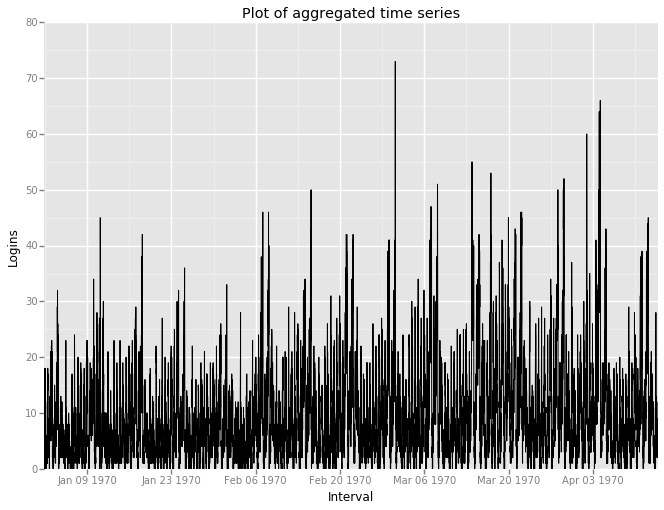

<ggplot: (273767433)>

In [4]:
ggplot(aes(x='Interval', y='Logins'), data=ts15) + geom_line() + ggtitle('Plot of aggregated time series')

There do not seem to be any discontinuities or linear trends. Maybe a couple of outliers at the beginning of March and April. The existence of a handful of large values is expected even under a regular distribution since we are sampling lots of observations. 

Let's look at average logins by day of week.

In [5]:
# generate days of week as a new column
ts15['DayOfWeek'] = ts15['Interval'].apply(lambda x: x.strftime('%A'))
ts15['IntervalHour'] = ts15['Interval'].apply(lambda x: x.replace(year=1900, month=1, day=1))

# ts15_grouped = ts15[['IntervalHour', 'DayOfWeek', 'Logins']].groupby(['DayOfWeek', 'IntervalHour']).mean().reset_index()
ts15_grouped = ts15.groupby(['DayOfWeek', 'IntervalHour']).agg([np.mean, np.std]).reset_index()
ts15_grouped.columns = ['DayOfWeek', 'IntervalHour', 'AvgLogins', 'SDLogins']

In [6]:
ts15_grouped.head()

,DayOfWeek,IntervalHour,AvgLogins,SDLogins
0,Friday,1900-01-01 00:00:00,15.800000,7.282072
1,Friday,1900-01-01 00:15:00,17.533333,5.139020
2,Friday,1900-01-01 00:30:00,15.466667,5.180550
3,Friday,1900-01-01 00:45:00,16.200000,5.479833
4,Friday,1900-01-01 01:00:00,17.266667,6.385997


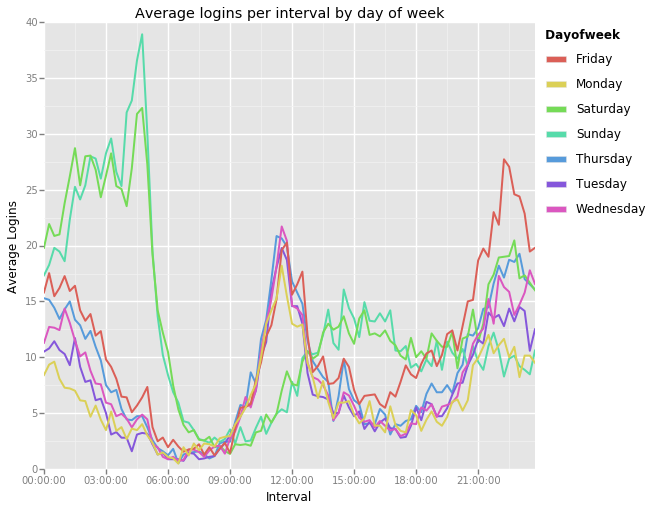

<ggplot: (297374525)>

In [7]:
ggplot(aes(x='IntervalHour', y='AvgLogins', color='DayOfWeek'), data=ts15_grouped) \
+ geom_line(size=2.0) \
+ ggtitle('Average logins per interval by day of week') \
+ xlab('Interval') + ylab('Average Logins')

As expected, weekdays and weekends display entirely different patterns. 

Amongst weekdays, Fridays and Mondays seem to have highest and lowest average demand levels repectively. While average peak demand just before noon is similar for all weekdays, the rate of change around it varies for each weekday.

Observing visually, these demand patterns are what one would expect for San Francisco but timestamped to EST. The two weekday peaks corresponding to rush hour demand seem shifted by 3 hours, as are the two "end of nightlife" peaks on Saturdays and Sundays.

Note: I also looked at these plots separated by month and the patterns look similar. Not showing those here for consiceness. 

Now let's look at the standard deviation.

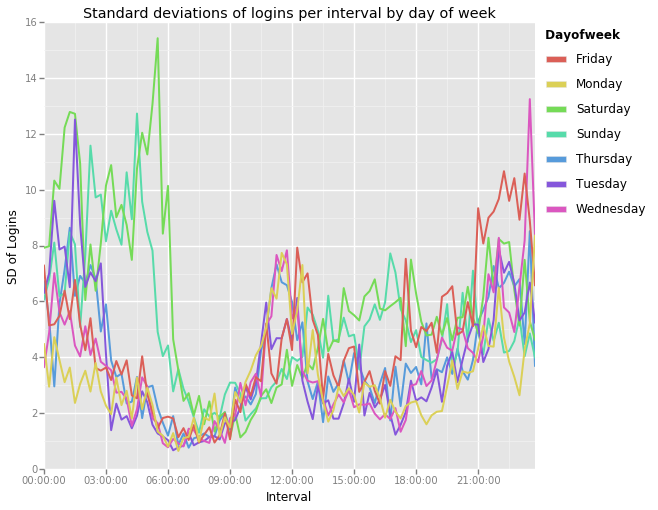

<ggplot: (297497361)>

In [8]:
ggplot(aes(x='IntervalHour', y='SDLogins', color='DayOfWeek'), data=ts15_grouped) \
+ geom_line(size=2.0) \
+ ggtitle('Standard deviations of logins per interval by day of week') \
+ xlab('Interval') + ylab('SD of Logins')

Looks like interval standard deviations are not constant but proportional to interval means. Let's see if we use a variance stabilizing transformation to get them closer to constant. If not, we may need to resort to an ARCH/GARCH model on the variance.

Since we dealing with counts data in a finite interval and standard deviations look proportional to means, a good choice to begin with is $$f(X) = \sqrt{X + \frac{3}{8}}$$

See notes at http://www.stat.purdue.edu/~dasgupta/vst.pdf for why the 3/8 needs to be added.



In [9]:
# apply transformation to aggregated logins counts
ts15_transformed = ts15.copy()
ts15_transformed['LoginsTransformed'] = ts15_transformed['Logins'].apply(lambda x: np.sqrt(x + 3.0/8.0))
ts15_transformed.drop('Logins', axis=1, inplace=True)
ts15_transformed.head(5)

,Interval,DayOfWeek,IntervalHour,LoginsTransformed
0,1970-01-01 20:15:00,Thursday,1900-01-01 20:15:00,2.524876
1,1970-01-01 20:30:00,Thursday,1900-01-01 20:30:00,3.061862
2,1970-01-01 20:45:00,Thursday,1900-01-01 20:45:00,2.715695
3,1970-01-01 21:00:00,Thursday,1900-01-01 21:00:00,1.172604
4,1970-01-01 21:15:00,Thursday,1900-01-01 21:15:00,2.091650


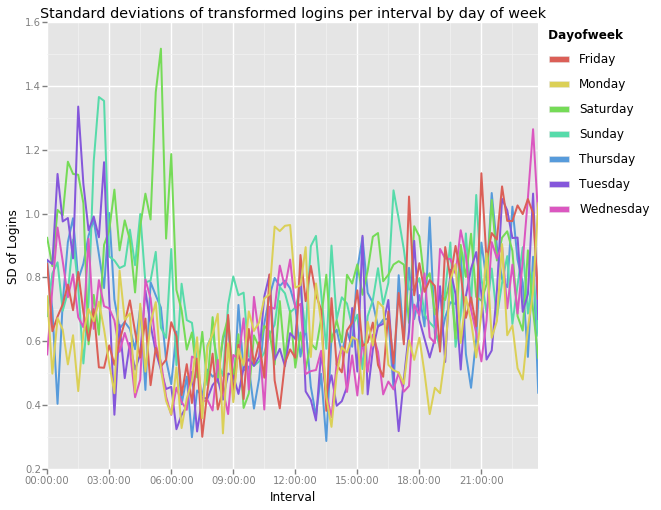

<ggplot: (297474141)>

In [10]:
# mean and sd of transformed data
ts15_transformed_grouped = ts15_transformed.groupby(['DayOfWeek', 'IntervalHour']).agg([np.mean, np.std]).reset_index()
ts15_transformed_grouped.head()
ts15_transformed_grouped.columns = ['DayOfWeek', 'IntervalHour', 'AvgLoginsTransformed', 'SDLoginsTransformed']

# plot sd of transformed data
ggplot(aes(x='IntervalHour', y='SDLoginsTransformed', color='DayOfWeek'), data=ts15_transformed_grouped) \
+ geom_line(size=2.0) \
+ ggtitle('Standard deviations of transformed logins per interval by day of week') \
+ xlab('Interval') + ylab('SD of Logins')

This looks much better but not entirely perfect. We should still check the residuals of any model to ensure that we don't need a variance heteroscedasticity model. Let's wrap up by looking at transformed means and make sure nothing weird happened.

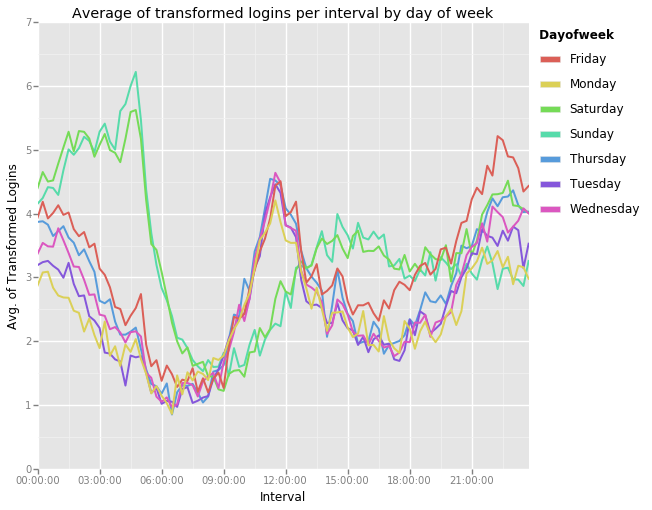

<ggplot: (297406921)>

In [11]:
# plot means of transformed data
ggplot(aes(x='IntervalHour', y='AvgLoginsTransformed', color='DayOfWeek'), data=ts15_transformed_grouped) \
+ geom_line(size=2.0) \
+ ggtitle('Average of transformed logins per interval by day of week') \
+ xlab('Interval') + ylab('Avg. of Transformed Logins')

Note: I also looked at log transformation but that doesn't work as well as the modified square root.

We could also look at a power (Box-Cox) transform but because there are intraday mean patterns that vary by day of week, we will need to be careful about how geometric means are calculated. Probably need a lot more time to investigate that.

Let's look at the transformed data to make sure nothing weird has happened.

In [12]:
ts15_transformed.head()

,Interval,DayOfWeek,IntervalHour,LoginsTransformed
0,1970-01-01 20:15:00,Thursday,1900-01-01 20:15:00,2.524876
1,1970-01-01 20:30:00,Thursday,1900-01-01 20:30:00,3.061862
2,1970-01-01 20:45:00,Thursday,1900-01-01 20:45:00,2.715695
3,1970-01-01 21:00:00,Thursday,1900-01-01 21:00:00,1.172604
4,1970-01-01 21:15:00,Thursday,1900-01-01 21:15:00,2.091650


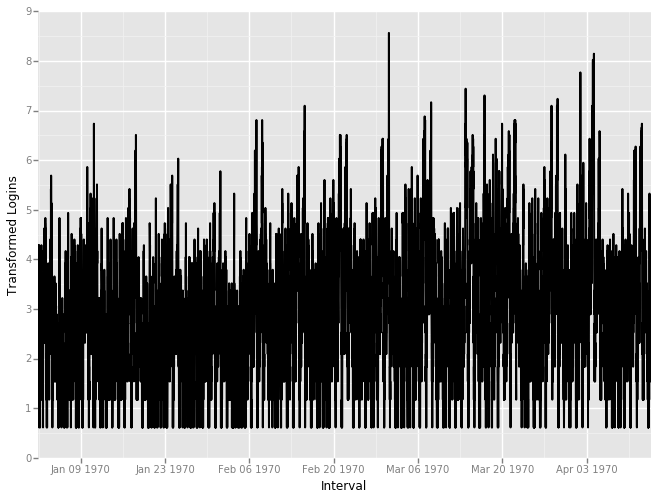

<ggplot: (297003029)>

In [13]:
# plot transformed data
ggplot(aes(x='Interval', y='LoginsTransformed'), data=ts15_transformed) \
+ geom_line(size=2.0) \
+ xlab('Interval') + ylab('Transformed Logins')

#### Summary of initial findings

The usual goal of exploring a time series to be able to create a causal time series model composed of a systematic component and a stationary process. Looking at 15-minutes aggregated logins data, we find
* Seasonality at the weekly level 
    * There could be annual seasonality but we need a longer history to confirm that
* Systematic variation of average logins by time of day
    * This variation differs by day of week
    * Weekend vs. weekday effects are strong
    * Amongst weekdays, we notice the same general pattern with small variations
* Standard deviation of logins seems proportional to the averages
    * Variance stabilizing transform of $\sqrt{X + 3/8}$ does a decent job of fixing that



#### Box-Jenkins for ARIMA 

Let's look at ACF and PACF plots on the transformed data to figure out a viable ARIMA model.

In [14]:
# beginning again with transformation for a clean restart
ts15_transformed = ts15.copy()
ts15_transformed['LoginsTransformed'] = ts15_transformed['Logins'].apply(lambda x: np.sqrt(x + 3/8))

# pull the raw series out and call it y for simplicity
y = pd.Series(ts15_transformed['LoginsTransformed'], name='LoginsTransformed')
y.index = pd.DatetimeIndex(ts15_transformed['Interval'])
y.index.name = 'Interval'

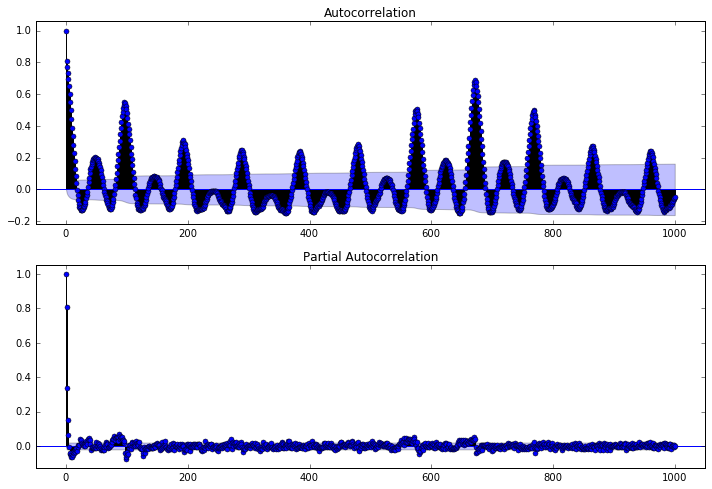

In [15]:
# ACF and PACF of y
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = statsmodels.graphics.tsaplots.plot_acf(y, lags=1000, ax=ax1)
ax2 = fig.add_subplot(212)
fig = statsmodels.graphics.tsaplots.plot_pacf(y, lags=1000, ax=ax2)

So, $y$ is a no-go since all sorts of autocorrelations exist. The strongest autocorrelation is present at a week's difference. Let's take out weekly seasonality and look at it again.

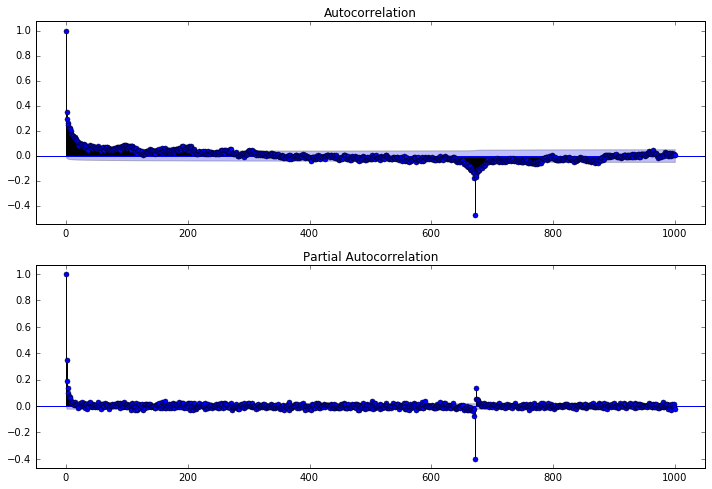

In [16]:
# A week has 672 15-minutes intervals
yd = y - y.shift(672)
yd.dropna(inplace=True)

# ACF and PACF of yd
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = statsmodels.graphics.tsaplots.plot_acf(yd, lags=1000, ax=ax1)
ax2 = fig.add_subplot(212)
fig = statsmodels.graphics.tsaplots.plot_pacf(yd, lags=1000, ax=ax2)

ACFs and PACFs for $y_d$ look better than those for $y$ but it's still not quite there. Let's look at a first difference of the de-seasonalized series.

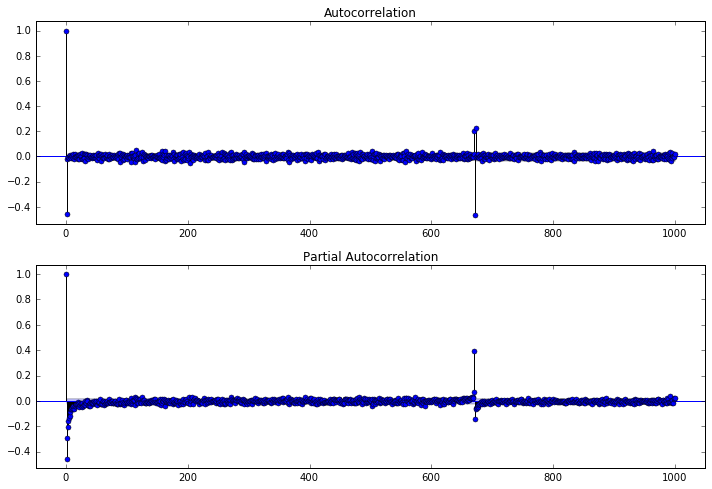

In [17]:
yd2 = yd - yd.shift(1)
yd2.dropna(inplace=True)

# ACF and PACF of yd
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = statsmodels.graphics.tsaplots.plot_acf(yd2, lags=1000, ax=ax1)
ax2 = fig.add_subplot(212)
fig = statsmodels.graphics.tsaplots.plot_pacf(yd2, lags=1000, ax=ax2)

Zooming in on the first few lags.

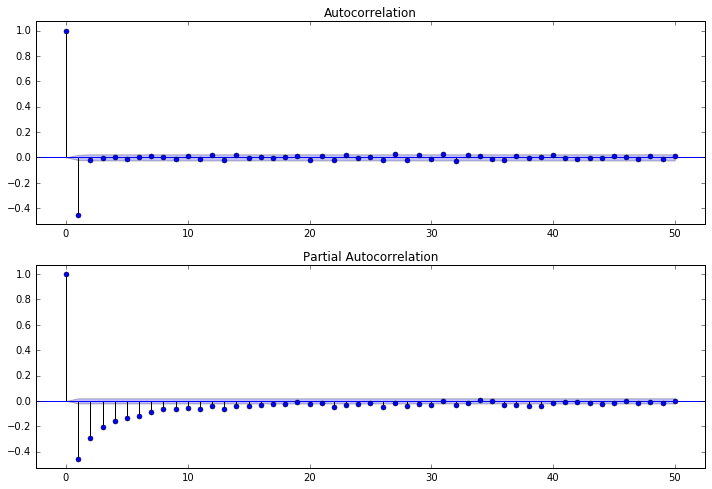

In [18]:
# ACF and PACF of yd
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = statsmodels.graphics.tsaplots.plot_acf(yd2, lags=50, ax=ax1)
ax2 = fig.add_subplot(212)
fig = statsmodels.graphics.tsaplots.plot_pacf(yd2, lags=50, ax=ax2)

Look's much better now. Let's do a test for stationarity.

In [19]:
#Perform Augmented Dickey-Fuller test yd2
from statsmodels.tsa.stattools import adfuller

print 'Results of Dickey-Fuller Test:'
dftest = adfuller(yd2, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test statistic','p-value','Num lags','Num observations'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

dfoutput 

Results of Dickey-Fuller Test:


Test statistic           -24.013372
p-value                    0.000000
Num lags                  38.000000
Num observations        9074.000000
Critical Value (5%)       -2.861859
Critical Value (1%)       -3.431071
Critical Value (10%)      -2.566940
dtype: float64

Looking at the plots above and the low p-value of the Augmented Dickey-Fuller test, we can feel pretty good about the transformed, weekly deseasonalized and first-order differenced time series being close to stationary. 

Let's save some data into files and move to a separate modeling notebook to create a forecasting model for this data.

In [21]:
# Start from raw data again for clarity
# convert to time series
ts_raw = pd.DataFrame(1, index=pd.to_datetime(raw_data['login_time']), columns=['Logins', ])

# aggregate to 15 minute intervals
ts15 = ts_raw.resample('15min', label='left').apply(lambda x: 0 if len(x) == 0 else sum(x))
ts15.columns = ['Logins', ]
ts15.index.name = 'Interval'

# remove first and last intervals to remove incomplete observations
ts15.drop(min(ts15.index), inplace=True)
ts15.drop(max(ts15.index), inplace=True)
ts15 = ts15.reset_index()

# apply transformation to aggregated logins counts
ts15_transformed = ts15.copy()
ts15_transformed['LoginsTransformed'] = ts15_transformed['Logins'].apply(lambda x: np.sqrt(x + 3.0/8.0))

# pull the raw series out and call it y for simplicity
y = pd.Series(ts15_transformed['LoginsTransformed'], name='LoginsTransformed')

# truncate y to begin after one complete seasonal period + 1
sp = 672  # seasonal period
y_trunc = y.drop(y.index[0:(sp + 1)])

# create covariates
exog = pd.concat([y.shift(sp), y.shift(sp - 1), y.shift(sp + 1)], axis=1)
exog.columns = ['ysp', 'ysp_m1', 'ysp_p1']
exog = exog.drop(exog.index[0:(sp + 1)])

# create future covariates
num_pred = 16
obs_end = max(exog.index)
new_exog = pd.DataFrame([y.loc[obs_end + 1 - sp], y.loc[obs_end - sp], y.loc[obs_end + 2 - sp]])
for i in range(obs_end + 2, obs_end + 1 + num_pred):
    new_exog = pd.concat([new_exog, pd.DataFrame([y.loc[i - sp], y.loc[i - sp - 1], 
                                                  y.loc[i - sp + 1]])], 
                          axis=1)
new_exog.columns = range(obs_end + 1, obs_end + 1 + num_pred)
new_exog = new_exog.transpose()
new_exog.columns = ['ysp', 'ysp_m1', 'ysp_p1']

# write to files
import os
out_folder = os.path.join('..', 'Data')
y.to_csv(os.path.join(out_folder, 'y.csv'), header=True)
y_trunc.to_csv(os.path.join(out_folder, 'y_trunc.csv'), header=True)
exog.to_csv(os.path.join(out_folder, 'exog.csv'), header=True)
new_exog.to_csv(os.path.join(out_folder, 'new_exog.csv'), header=True)

print('All done.')

All done.
